In [8]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import pandas as pd
from astropy.table import Table
from scipy.interpolate import interp1d
import sys
sys.path.append('../analysis')
import read_mist_models
import analysis_utils
from matplotlib import colors

highlight = np.array((66, 135, 245))/255
red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'
pl.rc('image', cmap='Spectral_r')

In [9]:
import os
data = pd.DataFrame()
for file in os.listdir('../output/txtoutput'):
    print("reading file: {0}".format(file))
    data = data.append(pd.read_csv('../output/txtoutput/'+file, skiprows=1, delimiter='\t'))

reading file: out8.dat
reading file: out18.dat
reading file: out16.dat
reading file: out112.dat
reading file: out17.dat
reading file: out15.dat
reading file: out111.dat
reading file: out14.dat
reading file: out13.dat
reading file: out102.dat
reading file: out12.dat
reading file: out3.dat
reading file: out2.dat
reading file: out0.dat
reading file: out1.dat
reading file: out5.dat
reading file: out4.dat
reading file: out6.dat
reading file: out7.dat


In [10]:
len(data)

372069

In [11]:
k2dr2 = Table.read('../analysis/k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic')
df = df.drop_duplicates(subset='epic_number')

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_result_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'r_modality_flag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: TableReplaceWarning: converted column 'k2_kepmagerr' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)


In [15]:
mistfile = '../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd'
g_rp_range = (0.0, 5.0)
width = (-0.6, 0.6)

iso = read_mist_models.ISOCMD(mistfile)
mist = iso.isocmds[iso.age_index(8.7)]

has_finite_g_rp = np.isfinite(df["g_rp"])
good_bp = df["phot_bp_mean_flux_error"]/df[u'phot_bp_mean_flux'] < 0.01
good_rp = df[u'phot_rp_mean_flux_error']/df[u'phot_rp_mean_flux'] < 0.01
good_mg = df[u'phot_g_mean_flux_error']/df[u'phot_g_mean_flux'] < 0.01
in_r_range = (df["r_est"] > 0) & (df["r_est"] < 600)
in_g_rp_range = (df["g_rp"] < 5.0) & df["g_rp"] > 0.2
mask = has_finite_g_rp & good_bp & good_rp & good_mg & in_r_range & in_g_rp_range

iso_g_rp = mist['Gaia_G_MAW'] - mist['Gaia_RP_MAW']
iso_mg = mist['Gaia_G_MAW']
mass_mask = (mist['initial_mass'] < 2.0) & (mist['initial_mass'] > 0.1)
iso_g_rp = iso_g_rp[mass_mask]
iso_mg = iso_mg[mass_mask]
interpolator = interp1d(iso_g_rp, iso_mg)
in_color_range = (df["g_rp"] > min(iso_g_rp)) & (df["g_rp"] < max(iso_g_rp))
mask = mask & in_color_range
iso_mg_interp = interpolator(df[mask]['g_rp'])
correction = 5 * np.log10(df[mask]["r_est"]) - 5 

Reading in: ../analysis/MIST_v1.2_feh_p0.50_afe_p0.0_vvcrit0.0_UBVRIplus.iso.cmd


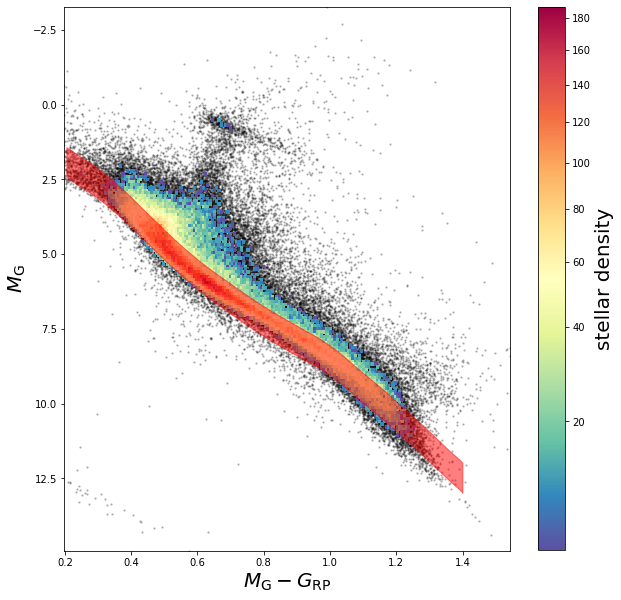

In [16]:
g_rp, mg = np.array(df[mask]["g_rp"]), np.array(df[mask]["phot_g_mean_mag"])-correction
is_ms = (mg - iso_mg_interp < 0.4) & (iso_mg_interp - mg < 0.4)

fig, ax = pl.subplots(figsize=(10, 10))

# only show 2D-histogram for bins with more than 10 stars in them
h = ax.hist2d(g_rp, mg, bins=200, cmin=10, norm=colors.PowerNorm(0.5), zorder=0.5)

# fill the rest with scatter
ax.scatter(g_rp, mg, alpha=0.2, s=2, color='k', zorder=0)
ax.fill_between(iso_g_rp[(iso_g_rp < 1.4) & (iso_g_rp > 0.2)], 
                iso_mg[(iso_g_rp < 1.4) & (iso_g_rp > 0.2)]+0.6, 
                iso_mg[(iso_g_rp < 1.4) & (iso_g_rp > 0.2)]-0.4, 
                alpha=0.5, color='r')
ax.invert_yaxis()
cb = fig.colorbar(h[3])
ax.set_xlabel(r'$M_\mathrm{G} - G_\mathrm{RP}$', fontsize=20)
ax.set_ylabel(r'$M_\mathrm{G}$', fontsize=20)
cb.set_label("stellar density", fontsize=20)
pl.savefig('/Users/tgordon/Desktop/cmd.pdf')
pl.show()